# **비지도학습 모델링**


## **1. 환경준비**

### (1) 라이브러리리

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### (2) 데이터 전처리

In [3]:
# 다운로드
train_set = MNIST(root='./data', train=True, transform=ToTensor(), download=True)
test_set = MNIST(root='./data', train=False, transform=ToTensor(), download=True)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 66.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.62MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.89MB/s]


## **2. 오토인코더 구현 1: MNIST 노이즈 제거**

### (1) 데이터에 노이즈 추가하기

In [ ]:
def add_noise(imgs, noise_factor=0.5):
    noisy_imgs = imgs + noise_factor * torch.randn_like(imgs)
    noisy_imgs = torch.clip(noisy_imgs, 0., 1.)
    return noisy_imgs

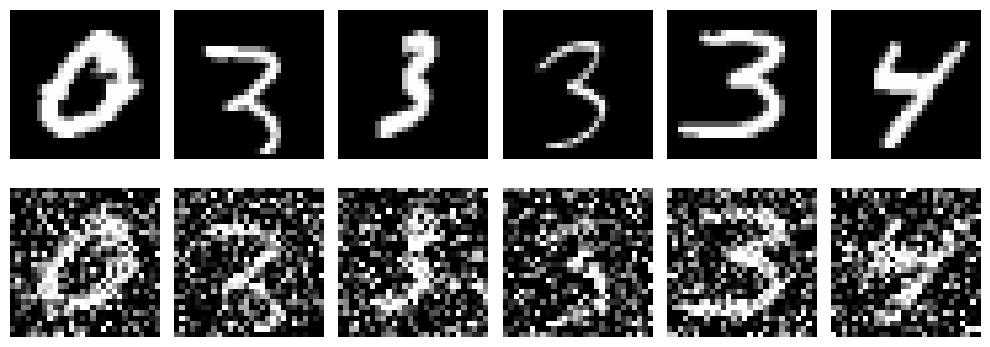

In [ ]:
x, _ = next(iter(train_loader))
noisy_x = add_noise(x)
plt.figure(figsize=(10, 4))
for i in range(6):
    # 원본 이미지
    plt.subplot(2, 6, i + 1)
    plt.imshow(x[i][0], cmap='gray')
    plt.axis('off')
    # 노이즈 이미지
    plt.subplot(2, 6, i + 7)
    plt.imshow(noisy_x[i][0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

### (2) 오토인코더 모델 구성

In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder: 784 → 128 → 64 → 32
        self.encoder = nn.Sequential(
        nn.Linear(28*28, 128), nn.ReLU(),
        nn.Linear(128, 64), nn.ReLU(),
        nn.Linear(64, 32), nn.ReLU() )
        # Decoder: 32 → 64 → 128 → 784
        self.decoder = nn.Sequential(
        nn.Linear(32, 64), nn.ReLU(),
        nn.Linear(64, 128), nn.ReLU(),
        nn.Linear(128, 28*28),
        nn.Sigmoid() ) # 픽셀 범위를 [0,1]로 맞추기 위해 시그모이드 함수 사용
    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.view(x.size(0), 1, 28, 28)

### (3) 모델 선언 및 학습

In [8]:
model = Autoencoder().to(device)
loss_fn = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [9]:
epochs = 20
for t in range(epochs):
    model.train()
    running_loss = 0.0
    for imgs, _ in train_loader:
        noisy_imgs = add_noise(imgs).to(device)
        imgs = imgs.to(device)
        outputs = model(noisy_imgs)
        loss = loss_fn(outputs, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    tr_loss = running_loss / len(train_loader)
    print(f"Epoch {t+1}, train loss: {tr_loss:.6f}")

Epoch 1, train loss: 0.069138
Epoch 2, train loss: 0.047450
Epoch 3, train loss: 0.036625
Epoch 4, train loss: 0.032392
Epoch 5, train loss: 0.030114
Epoch 6, train loss: 0.028505
Epoch 7, train loss: 0.027373
Epoch 8, train loss: 0.026342
Epoch 9, train loss: 0.025355
Epoch 10, train loss: 0.024472
Epoch 11, train loss: 0.023757
Epoch 12, train loss: 0.023047
Epoch 13, train loss: 0.022507
Epoch 14, train loss: 0.022068
Epoch 15, train loss: 0.021668
Epoch 16, train loss: 0.021412
Epoch 17, train loss: 0.021158
Epoch 18, train loss: 0.020967
Epoch 19, train loss: 0.020756
Epoch 20, train loss: 0.020492


### (4) 예측 및 결과 비교

In [10]:
model.eval()
imgs, _ = next(iter(test_loader))
noisy_imgs = add_noise(imgs).to(device)
with torch.no_grad():
    outputs = model(noisy_imgs)

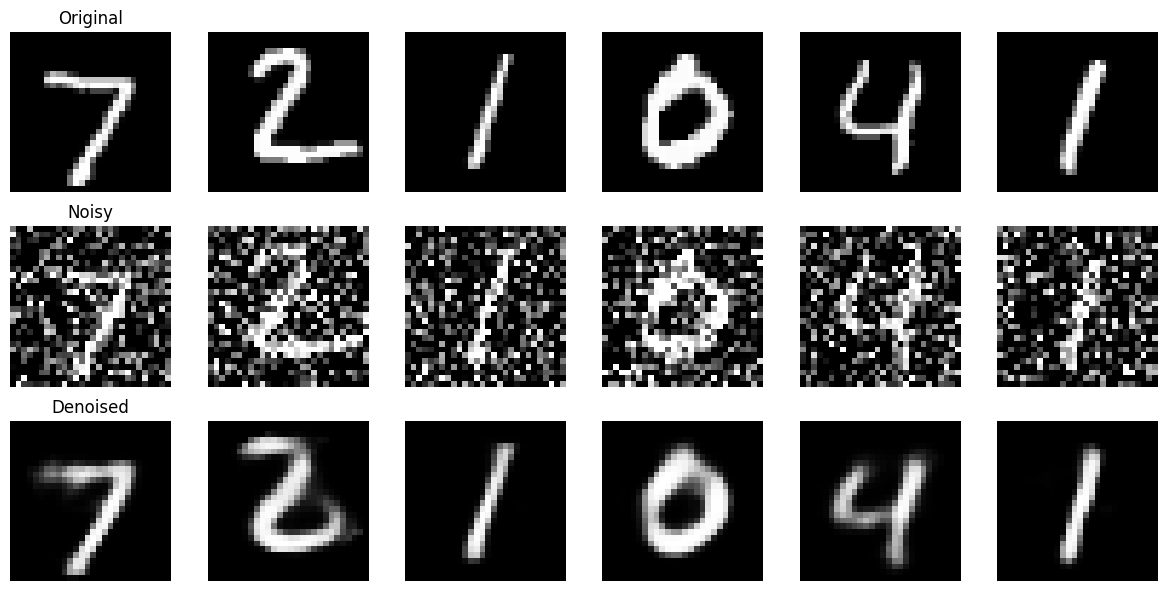

In [12]:
imgs = imgs[:6].cpu()
noisy_imgs = noisy_imgs[:6].cpu()
outputs = outputs[:6].cpu()
plt.figure(figsize=(12, 6))
for i in range(6):
    # 원본
    plt.subplot(3, 6, i + 1)
    plt.imshow(imgs[i][0], cmap='gray')
    plt.axis('off')
    if i == 0: plt.title("Original")
    # 노이즈
    plt.subplot(3, 6, i + 7)
    plt.imshow(noisy_imgs[i][0], cmap='gray')
    plt.axis('off')
    if i == 0: plt.title("Noisy")
    # 복원
    plt.subplot(3, 6, i + 13)
    plt.imshow(outputs[i][0], cmap='gray')
    plt.axis('off')
    if i == 0: plt.title("Denoised")

plt.tight_layout()
plt.show()

## **3. 오토인코더 구현 2: MNIST 차원 축소**


### (1) 모델 구성

In [11]:
class Autoencoder2D(nn.Module):
    def __init__(self):
        super(Autoencoder2D, self).__init__()
        self.encoder = nn.Sequential(
                        nn.Linear(784, 128), nn.ReLU(),
                        nn.Linear(128, 64), nn.ReLU(),
                        nn.Linear(64, 2))
        self.decoder = nn.Sequential(
                        nn.Linear(2, 64), nn.ReLU(),
                        nn.Linear(64, 128), nn.ReLU(),
                        nn.Linear(128, 784),
                        nn.Sigmoid())
    def forward(self, x):
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        out = self.decoder(z)
        return out.view(x.size(0), 1, 28, 28)
    def encode(self, x):
        x = x.view(x.size(0), -1)
        return self.encoder(x)

### (2) 모델 선언 및 학습

In [14]:
model = Autoencoder2D().to(device)
loss_fn = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

epochs = 20
for t in range(epochs):
    model.train() # 학습 모드
    running_loss = 0.0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        loss = loss_fn(outputs, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    tr_loss = running_loss / len(train_loader)
    print(f"Epoch {t+1}, train loss: {tr_loss:.6f}")

Epoch 1, train loss: 0.064003
Epoch 2, train loss: 0.050686
Epoch 3, train loss: 0.047323
Epoch 4, train loss: 0.045348
Epoch 5, train loss: 0.043983
Epoch 6, train loss: 0.043063
Epoch 7, train loss: 0.042339
Epoch 8, train loss: 0.041725
Epoch 9, train loss: 0.041250
Epoch 10, train loss: 0.040807
Epoch 11, train loss: 0.040409
Epoch 12, train loss: 0.040125
Epoch 13, train loss: 0.039771
Epoch 14, train loss: 0.039586
Epoch 15, train loss: 0.039326
Epoch 16, train loss: 0.039112
Epoch 17, train loss: 0.038920
Epoch 18, train loss: 0.038748
Epoch 19, train loss: 0.038583
Epoch 20, train loss: 0.038352


### (3) 모델 사용: 차원 축소

In [15]:
model.eval()
latent_vectors = []
labels = []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        z = model.encode(imgs)
        latent_vectors.append(z.cpu())
        labels.append(lbls)
latent_vectors = torch.cat(latent_vectors)
labels = torch.cat(labels)

### (4) 잠재 벡터 시각화

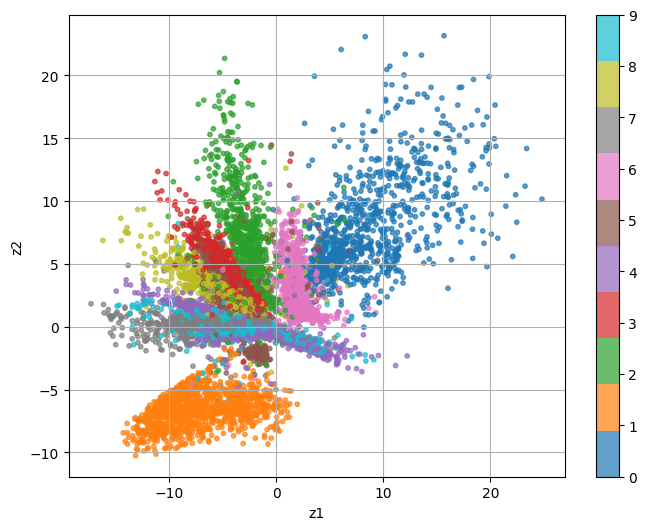

In [16]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap='tab10', s=10, alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.xlabel("z1")
plt.ylabel("z2")
plt.grid()
plt.show()